In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score

In [4]:
# 필요한 라이브러리 임포트
import re
import math
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.stats import entropy

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data = pd.read_csv("/content/phishing_site_urls.csv")

Mounted at /content/drive


In [5]:
data

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
42396,gswzmb.com/down/js/?ref=us.battle.net/d3/en/index,bad
42397,greentechenterprises.org/8secure/security/conf...,bad
42398,greentechenterprises.org/7secure/security/conf...,bad
42399,greekeventsnet.gr/remax/,bad


In [6]:
# Label 열의 각 값의 개수 출력
data['Label'].value_counts()

,count
Label,
bad,42306
good,94


In [7]:
# 피싱 URL과 정상 URL 구분
phishing_urls = data[data['Label'] == 'bad']['URL']
benign_urls = data[data['Label'] == 'good']['URL']

# 피싱 URL에서 단어 추출 및 빈도 계산
phishing_word_counts = Counter()
for url in phishing_urls:
    words = re.findall(r'[a-zA-Z]+', url.lower())
    phishing_word_counts.update(words)

# 정상 URL에서 단어 추출 및 빈도 계산
benign_word_counts = Counter()
for url in benign_urls:
    words = re.findall(r'[a-zA-Z]+', url.lower())
    benign_word_counts.update(words)

의심스러운 단어 목록: ['nobell', 'ffb', 'dca', 'cce', 'skype', 'cgi', 'bin', 'verification', 'php', 'cmd']


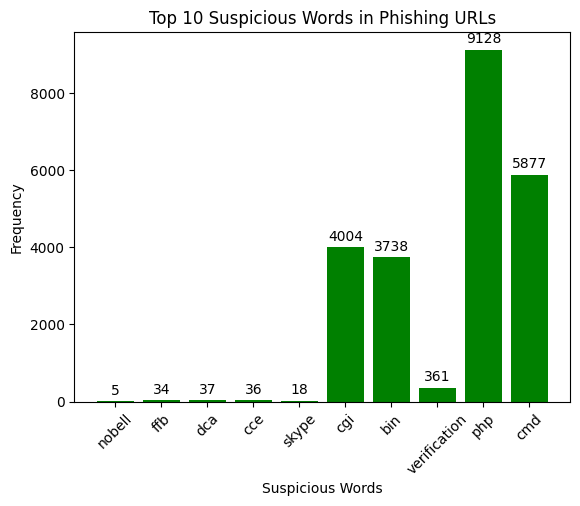

In [8]:
# 피싱 URL에만 존재하는 단어 추출 (정상 URL에 포함되지 않은 단어만)
suspicious_words = [word for word, count in phishing_word_counts.items() if word not in benign_word_counts]
suspicious_words = suspicious_words[:10]  # 상위 10개 단어만 선택
print("의심스러운 단어 목록:", suspicious_words)

# 단어와 빈도수 시각화 준비
suspicious_word_counts = {word: phishing_word_counts[word] for word in suspicious_words}

# 그래프 그리기
plt.bar(suspicious_word_counts.keys(), suspicious_word_counts.values(), color='green')
plt.xlabel('Suspicious Words')
plt.ylabel('Frequency')
plt.title('Top 10 Suspicious Words in Phishing URLs')
plt.xticks(rotation=45)
# 빈도 수를 막대 위에 표시
for i, (word, freq) in enumerate(suspicious_word_counts.items()):
    plt.text(i, freq + 100, str(freq), ha='center', va='bottom')

plt.show()

In [9]:
# 주요 특징을 추출하는 함수 정의
def extract_features(url):
    features = {}
    # 1) URL의 길이
    features['url_length'] = len(url)

    # 2) IP 주소 사용 여부
    features['ip_usage'] = 1 if re.search(r'\d+\.\d+\.\d+\.\d+', url) else 0

    # 3) 하위 도메인의 수
    domain = url.split('/')[2] if '://' in url else url.split('/')[0]
    features['subdomain_count'] = domain.count('.') - 1

    # 4) 의심스러운 단어 빈도 (학습한 의심스러운 단어 목록 사용)
    features['suspicious_word_count'] = sum(word in url.lower() for word in suspicious_words)

    # 5) URL의 엔트로피
    char_counts = pd.Series(list(url)).value_counts(normalize=True)
    features['entropy'] = -sum(char_counts * np.log2(char_counts))

    return pd.Series(features)

In [10]:
# 각 URL에 대해 특징 추출
features_df = data['URL'].apply(extract_features)
features_df['Label'] = data['Label']  # 레이블 추가

In [11]:
# 데이터셋에 새로운 컬럼으로 추가
features_df = data['URL'].apply(extract_features)
df = pd.concat([data, features_df], axis=1)

# 데이터프레임 확인
df.head()

,URL,Label,url_length,ip_usage,subdomain_count,suspicious_word_count,entropy
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,225.0,0.0,0.0,10.0,5.026886
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,81.0,0.0,1.0,4.0,4.686883
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,177.0,0.0,0.0,2.0,4.721044
3,mail.printakid.com/www.online.americanexpress....,bad,60.0,0.0,1.0,0.0,4.079842
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,116.0,0.0,0.0,0.0,4.608653


In [13]:
# 언더샘플링 수행
bad_count = df[df['Label'] == 'bad'].shape[0]
good_df = df[df['Label'] == 'good'].sample(n=bad_count, random_state=42, replace=True)
balanced_df = pd.concat([df[df['Label']== 'bad'], good_df])

In [14]:
# 언더샘플링된 데이터셋으로 특징과 레이블 분리
X = balanced_df.drop(['Label', 'URL'], axis=1)
y = balanced_df['Label']

# 데이터셋 확인
print("언더샘플링 후 데이터셋의 클래스 분포:\n", y.value_counts())

언더샘플링 후 데이터셋의 클래스 분포:
 Label
bad     42306
good    42306
Name: count, dtype: int64


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# 모델 정의
logreg = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier()
rfc = RandomForestClassifier()
svc = SVC()

In [16]:
# 학습 및 평가 함수
def train_test_model(model, X, y, training_percentage):
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=1-training_percentage, stratify=y, random_state=42)
    model.fit(trainX, trainY)
    predY = model.predict(testX)
    accuracy = accuracy_score(testY, predY)
    precision = precision_score(testY, predY, pos_label='bad')
    recall = recall_score(testY, predY, pos_label='bad')
    return accuracy, precision, recall

In [17]:
# 다양한 학습 비율을 설정
training_sizes = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [18]:
# 모델별 결과 저장
def model_results(model):
    results = []
    for p in training_sizes:
        results.append(train_test_model(model, X, y, p))
    return pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall'])

In [19]:
# 모델별 결과
logreg_results = model_results(logreg)
knn_results = model_results(knn)
dtree_results = model_results(dtree)
rfc_results = model_results(rfc)
svc_results = model_results(svc)

In [20]:
# 모든 모델 결과 모음
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'SVM']
model_results = [logreg_results, knn_results, dtree_results, rfc_results, svc_results]

In [21]:
# 결과를 저장하는 리스트
accuracies = []
precisions = []
recalls = []

# 각 모델별로 성능 지표 추출
for model in model_results:
    accuracies.append(model.Accuracy.values)
    precisions.append(model.Precision.values)
    recalls.append(model.Recall.values)


In [22]:
# DataFrame으로 변환하여 보기 쉽게 정리
accuracies = pd.DataFrame(np.transpose(accuracies), columns=models, index=training_sizes*100)
precisions = pd.DataFrame(np.transpose(precisions), columns=models, index=training_sizes*100)
recalls = pd.DataFrame(np.transpose(recalls), columns=models, index=training_sizes*100)

# 성능 결과 출력
print("Accuracies:\n", accuracies)
print("\nPrecisions:\n", precisions)
print("\nRecalls:\n", recalls)

Accuracies:
       Logistic Regression       KNN  Decision Tree  Random Forest       SVM
10.0             0.916679  0.998214       0.999750       0.999829  0.878465
20.0             0.909765  0.999158       0.999793       0.999956  0.946905
30.0             0.911749  0.999578       0.999865       0.999949  0.965338
40.0             0.914139  0.999567       0.999902       0.999941  0.971242
50.0             0.912187  0.999622       0.999905       0.999882  0.974117
60.0             0.913163  0.999675       0.999911       0.999941  0.974826
70.0             0.913528  0.999764       0.999921       0.999921  0.975693
80.0             0.915263  0.999705       0.999941       0.999941  0.976659
90.0             0.918695  0.999527       1.000000       1.000000  0.978138

Precisions:
       Logistic Regression  KNN  Decision Tree  Random Forest       SVM
10.0             0.933353  1.0            1.0            1.0  0.898620
20.0             0.932323  1.0            1.0            1.0  0.976649


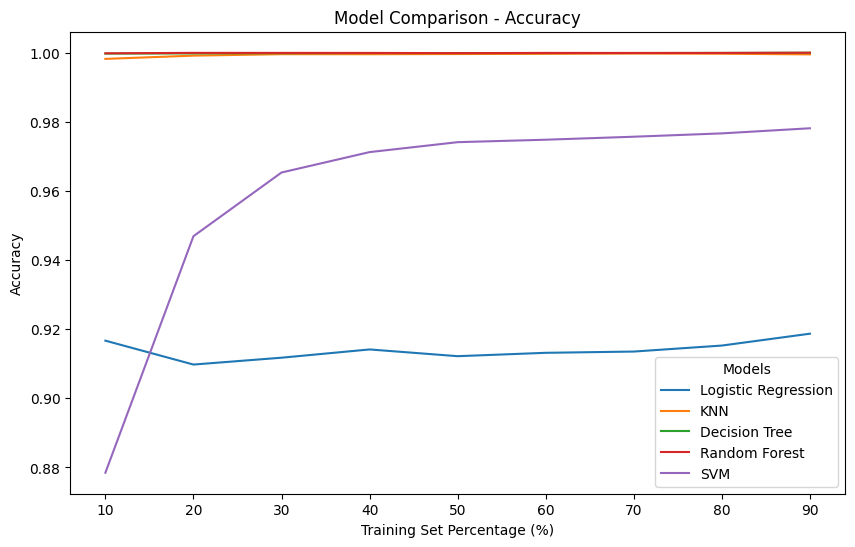

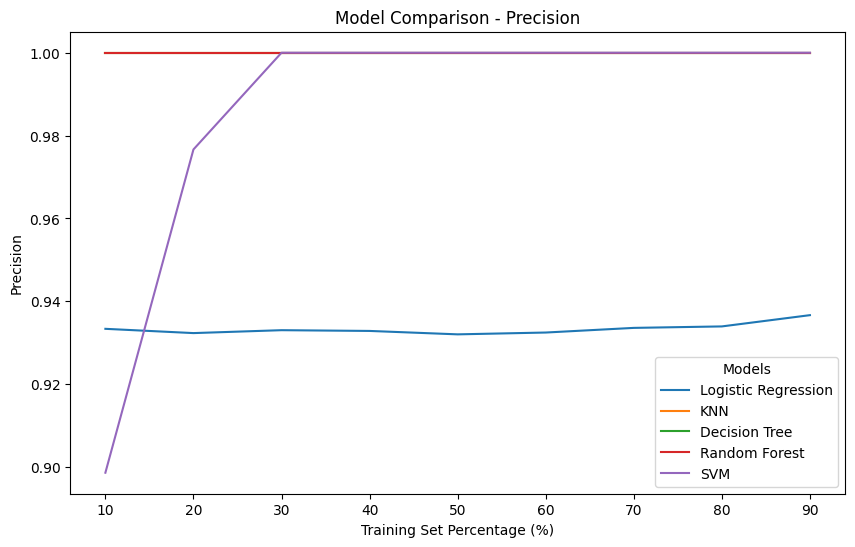

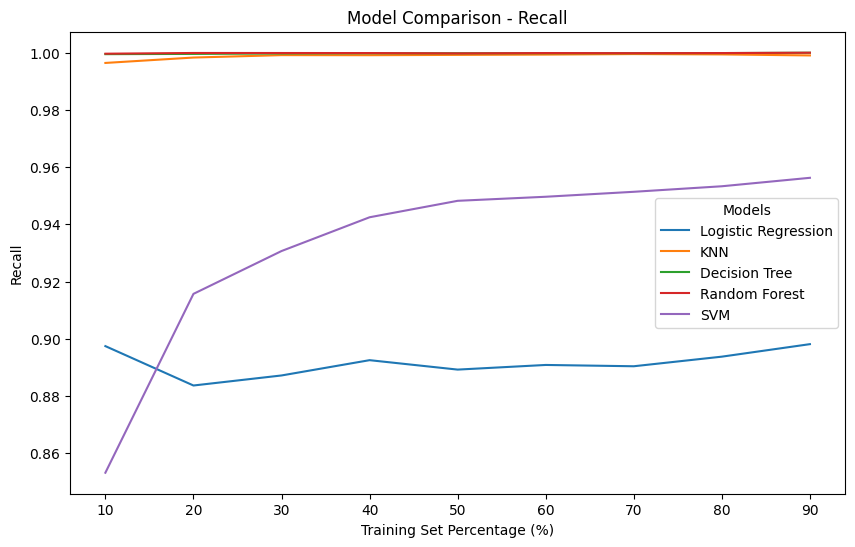

In [23]:
# 결과 그래프 출력
accuracies.plot(figsize=(10, 6))
plt.title("Model Comparison - Accuracy")
plt.xlabel("Training Set Percentage (%)")
plt.ylabel("Accuracy")
plt.legend(title="Models")
plt.show()

precisions.plot(figsize=(10, 6))
plt.title("Model Comparison - Precision")
plt.xlabel("Training Set Percentage (%)")
plt.ylabel("Precision")
plt.legend(title="Models")
plt.show()

recalls.plot(figsize=(10, 6))
plt.title("Model Comparison - Recall")
plt.xlabel("Training Set Percentage (%)")
plt.ylabel("Recall")
plt.legend(title="Models")
plt.show()